<a href="https://colab.research.google.com/github/vanheukelomdean/squatrack/blob/master/cpm_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive and count images files in dataset


In [10]:
from google.colab import drive
import os
import shutil

drive_dir = "/content/drive/My Drive/Datasets/"
targz_path = "mpii_human_pose_v1.tar.gz"
extract_dir = "images/"

drive.mount("/content/drive", force_remount=True)

path = drive_dir + extract_dir
file_count = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

print ("There are " + str(file_count) + " files in directory.")

Mounted at /content/drive
There are 5488 files in directory.


Importing utilities and libraries for file systems, datasets, image processing, and learning

In [11]:
!pip install console-progressbar

import itertools
from os.path import join

import numpy as np
import pandas as pd
import scipy.io as sio

from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from console_progressbar import ProgressBar

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Layer, experimental
from tensorflow.keras.losses import MeanSquaredError

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
GPU is available


Define the convolutional pose machine architecture:

 - It has n stages where n > 1

 - Initial stage is comprised of:
     - Interleaved convolutional and pooling layers for feature recognition with translational invariance
     - Two fully connected layers for classification of the most abstract features
 - Each subsequent stage is comprised of 
    - Interleaved convolutional and pooling layers for feature recognition performed on the input image
    - Concatenation of the belief maps from above and the previous stage
    - Three further convolutional layers
    - Two fully connected layers for classification of the most abstract features
    - A intermediate loss calculation to cache
 - The stage loss is aggregated in place of end-of-model loss calculattion to reduce the risk of the vanishing gradient problem encountered in some feed forward neural nets



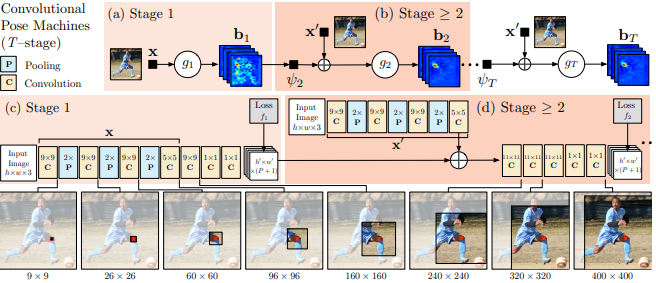


In [ ]:
class StageLoss(keras.layers.Layer): 
  def __init__(self, name, parent_model, num_outputs, loss_function = MeanSquaredError()):
    super(StageLoss, self).__init__()
    self.name = name
    self.parent_model = parent_model
    self.loss_function = loss_function
    self.num_outputs = num_outputs

  def call(self, inputs):
    stage_loss = self.loss_function((y_true, inputs).numpy())
    self.parent_model.setLoss(stage_loss)
    return inputs

In [15]:
STAGE_1_LAYERS = 11
STAGE_T_INPUT_LAYERS = 7
STAGE_T_CONCAT_LAYERS = 5

class ConvPoseMachine (keras.models.Sequential):
  def __init__(self, num_stages, num_parts):
      super(ConvPoseMachine, self).__init__()
      assert num_stages > 1, "There must be at least an initial and subsequent stage"
      self.num_stages = num_stages
      self.num_parts = num_parts
      self.stage = 0
      self.loss = 0
      self.total_loss = 0
      self.build_model()
      
  def build_model(self):
    filters = self.num_parts + 1
    layers  = []
    """
        Initial Stages
    """

    # Normalize
    layers.append(experimental.preprocessing.Rescaling(1./255))


    # Triple 9x9 conv encoder
    for i in range (3):
      layers.append(Conv2D(filters,
                            name="conv-1-" + str(i + 1) +'-9x9',
                            kernel_size=[9, 9],
                            activation='relu'))
      layers.append(MaxPooling2D(name="pool-1-" + str(i + 1),
                                 pool_size=(2, 2)))

    layers.append(Conv2D(filters,
                          name="conv-1-4-5x5",
                          kernel_size=[5, 5],
                          activation='relu'))
    
    # Finishing 11x11 conv
    layers.append(Conv2D(filters,
                          name="conv-1-5-9x9", 
                          kernel_size=[9, 9],
                          activation='relu'))
    
    # Fully connnected layer for classification of the most abstract features
    layers.append(Conv2D(filters,
                          name="conv-1-6-1x1",
                          kernel_size=[1, 1],
                          activation='relu'))
    layers.append(Conv2D(filters,
                          name="conv-1-7-1x1",
                          kernel_size=[1, 1],
                          activation='relu'))
    
    # Measure loss at each stage
    layers.append(StageLoss(name="loss-1",
                            parent_model=self,
                            num_outputs=filters))

    """
        Subsequent Stages
    """
    
    for s in range (1, self.num_stages):
      # Triple 9x9 conv, 5x5 conv
      for i in range (3):
        layers.append(Conv2D(filters,
                              name="conv-" + s + "-" + str(i + 1) +'-9x9',
                              kernel_size=[9, 9],
                              activation='relu'))
        layers.append(MaxPooling2D(name="pool-" + s + "-" + str(i + 1),
                                    pool_size=(2, 2)))

      layers.append(Conv2D(filters,
                            name="conv-" + s + "-3-5x5",
                            kernel_size=[5, 5],
                            activation='relu'))
      
      # Concat belief map and previous stage feature map
      for i in range (3):
        layers.append(Conv2D(filters,
                              name="conv-" + s + "-" + i + "-11x11",
                              kernel_size=[11, 11],
                              activation='relu'))
      layers.append(Conv2D(filters,
                            name="conv-" + s + "-4-1x1",
                            kernel_size=[1, 1],
                            activation='relu'))
      layers.append(Conv2D(filters,
                            name="conv-" + s + "-5-1x1",
                            kernel_size=[1, 1],
                            activation='relu'))
      layers.append(StageLoss(name="loss-" + s ,
                              parent_model=self,
                              num_outputs=filters))

    self.nn_layers = layers

  def call(self, img, x_n = None):
    global STAGE_1_LAYERS, STAGE_T_INPUT_LAYERS, STAGE_T_CONCAT_LAYERS
    if self.stage == 0:
      for l in range (0, STAGE_1_LAYERS):
        print(self.nn_layers[l].name)
        img = self.nn_layers[l](img)
      return img

    else: 
      for l in range (self.stage, self.stage + STAGE_T_INPUT_LAYERS):
        img = self.layers[l](img)
    
      maps = tf.concat(img, x_n)

      for l in range (self.stage, self.stage + STAGE_T_CONCAT_LAYERS):
        maps = self.nn_layers[l](maps)
      return maps

  def setLoss(self, stage_loss):
    assert stage_loss > 0, "Stage loss less than zero"
    self.loss = value
    self.total_loss += self.loss

Define bounding box class for redimensioning image centered on the subject

In [16]:
class BoundingBox():
  def __init__(self, points):
    self.top_left =  np.min(points, axis=0)
    self.bottom_right = np.max(points, axis=0)
    self.update_whc()

  def update_whc(self):
    self.width = np.abs(self.bottom_right[0] - self.top_left[0])
    self.height = np.abs(self.bottom_right[1] - self.top_left[1])
    self.center = np.array(self.top_left[0] + self.width/2, self.top_left[1] + self.height/2)

  def rescale(self, scalingFactor):
    # Multiply with unsafe casting
    self.top_left = (self.top_left * scalingFactor)
    self.bottom_right = (self.top_left * scalingFactor)
    self.update_whc()

  def expand (self, size):
    expansion_vector = np.array([(size - self.width)/2, (size - self.height)/2]) 
    self.top_left -= expansion_vector
    self.bottom_right += expansion_vector
    self.update_whc()

  def tl_br (self):
    return tuple(self.top_left.astype(int)), tuple(self.bottom_right.astype(int))

Reorganize matlab structure into pandas dataframe

In [17]:
MPII_FIELDS = ['NAME','r ankle_X','r ankle_Y', 'r knee_X','r knee_Y', 'r hip_X',
               'r hip_Y', 'l hip_X','l hip_Y', 'l knee_X','l knee_Y', 'l ankle_X',
               'l ankle_Y','pelvis_X','pelvis_Y','thorax_X','thorax_Y','upper neck_X',
               'upper neck_Y', 'head top_X','head top_Y', 'r wrist_X','r wrist_Y',
               'r elbow_X','r elbow_Y', 'r shoulder_X','r shoulder_Y','l shoulder_X',
               'l shoulder_Y','l elbow_X','l elbow_Y', 'l wrist_X','l wrist_Y','Scale',
               'Activity','Category']

DATASET_SIZE = 24984 / 100

class MpiiDataset():
  def __init__(self, image_dir, annotation_path, train=True, shuffle=True, csv=False):
    self.network_input_dim = 368
    self.train = train
    self.shuffle = shuffle
    self.image_dir = image_dir
    self.bboxes = {}

    print("Loading annotations...")

    pb = ProgressBar(total=100, decimals=0, length=50, fill='X', zfill='-')

    release = sio.loadmat(annotation_path, struct_as_record=False)['RELEASE']

    print("Transforming annotations...")

    obj = release[0,0]

    annolist = obj.__dict__['annolist']
    train_flags = obj.__dict__['img_train']
    act = obj.__dict__['act']

    self.labels = pd.DataFrame(columns=MPII_FIELDS)

    # for each annotated image record
    for i in range(0,annolist.shape[1]):

      # Only save training or test images
      if not train_flags[0,i] == self.train:
        continue

      temp = []
      obj_list = annolist[0,i]
      obj_act = act[i,0]
      
      rect =obj_list.__dict__['annorect']
      img_d = obj_list.__dict__['image']

      if rect.shape[0] == 0:
        continue
          
      obj_rect = rect[0,0]
      obj_img = img_d[0,0]

      if 'annopoints' not in obj_rect._fieldnames:
        continue
      
      # Write image name to record
      name = obj_img.__dict__['name'][0]
      annopoints = obj_rect.__dict__['annopoints']
      
      if annopoints.shape[0]==0:
        continue

      points = annopoints[0,0].__dict__['point']

      temp.append(name)
    
      # Set default keypoint coordinate value -1
      for n in range(0,32):
        temp.append(-1)

      keypoints = []
      # Write keypoints to record
      for px in range(0,points.shape[1]):
        point = points[0,px]
        id = point.__dict__['id']
        x = point.__dict__['x']
        y = point.__dict__['y']
        array_index = 2 * id[0][0] + 1
        temp[array_index] = x[0][0]
        temp[array_index+1] = y[0][0]
        keypoints.append((x[0][0], y[0][0]))
      
      # Store bboxes in seperate map from dataframe
      self.bboxes[str(name)] = BoundingBox(keypoints)

      # Write ratio of box size to 200px height
      scale = obj_rect.__dict__['scale'][0][0]
      temp.append(scale)

      # Write activity/category, take the first index if passed list
      activity = act[i,0]
      activity_name = activity.act_name
      category_name = activity.cat_name

      if activity_name.shape[0]==0:
          temp.append(activity_name)
      else:
          temp.append(activity_name[0])
      if category_name.shape[0]==0:
          temp.append(category_name)
      else:
          temp.append(category_name[0])

      self.labels = pd.concat([self.labels, pd.DataFrame([temp],columns=MPII_FIELDS)])

      pb.print_progress_bar(int(i / DATASET_SIZE)) 
      
    print("\n" + ("Training" if self.train else "Testing") + " annotations dataframe (size " + str(self.labels.shape) + ") loaded")

    if (csv):
      file_name = "train" if self.train else "test" + '_mpii.csv'
      data.to_csv(file_name)
      print("Dataset written to " + file_name)


  def preprocess_image(self, image_name):

    image_path = join(image_dir, image_name)
    image = cv2.imread(image_path)

    # Cache image keypoints and human's bounding box
    label = self.labels[self.labels['NAME'].str.contains(image_name)]
    bbox = self.bboxes[image_name]

    top_left, bottom_right = bbox.tl_br()

    # Scale image to have human roughly 200 px in height
    targetHeight = 200.0
    scalingFactor = targetHeight / bbox.height
    image = cv2.resize(image, (0, 0), fx=scalingFactor, fy=scalingFactor)
    bbox.rescale((scalingFactor, scalingFactor))

    top_left, bottom_right = bbox.tl_br()

    bbox.expand(self.network_input_dim)

    half_cross = np.full((1, 2), self.network_input_dim / 2).astype(int)[0]
    full_cross = np.add(half_cross, half_cross)
    half_cross_tuple = (self.network_input_dim // 2,  self.network_input_dim // 2)

    # Pad image with black
    pad_image = np.pad(image, (half_cross_tuple, half_cross_tuple, (0, 0)), mode='constant')

    # Add margin to bounding box top left for cropping start and image diagonal for cropping end
    start = np.add(bbox.top_left.astype(int), half_cross)
    end =  np.add(start, full_cross)

    # Crop image to network input dimensions with human centered
    crop_image = pad_image[start[1]:end[1], start[0]:end[0]]

    # Perform similar transformations on laabeled annotations
    labelX = (np.array(label.iloc[:, 1:32:2])* scalingFactor + half_cross[0] - start[0]).astype(np.int32)[0]
    labelY = (np.array(label.iloc[:, 2:33:2])* scalingFactor + half_cross[0] - start[1]).astype(np.int32)[0]
    indices = range(0, len(labelX))
    
    transformed_labels = list(map(lambda x: (labelX[x], labelY[x]), indices))
    #transformed_labels = np.hstack([labelY, labelX])

    return crop_image, transformed_labels

  def get_data(self, images):

    # shuffle all labels
    if self.shuffle:
        self.labels = self.labels.sample(frac=1).reset_index(drop=True)

    # compute label-image set intersection
    valid_dataset = list (set(images) & set(mpii.bboxes.keys()))

    for image_name in valid_dataset:
      yield self.preprocess_image(image_name)


Loading annotations...
Transforming annotations...
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX| 100% 

Training annotations dataframe (size (17372, 36)) loaded


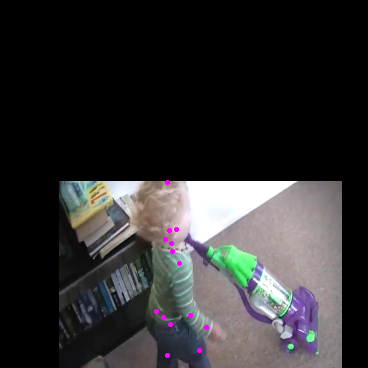

error: ignored

In [18]:
image_dir = "/content/drive/My Drive/Datasets/images/"
annotation_dir = "/content/drive/My Drive/Datasets/mpii_human_pose_annotation.mat"

images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

mpii = MpiiDataset(image_dir, annotation_dir)

Y = mpii.get_data(images) 

for y_image, y_keypoints in Y:
  if y_image is not None:
    for coordinate in y_keypoints:
      cv2.circle(y_image, coordinate, 1, (255,0, 255), 2)
    cv2_imshow(y_image)



In [ ]:
mpii = MpiiDataset(image_dir, annotation_dir)

my_list = list (set(images) & set(mpii.bboxes.keys()))

print(my_list)

Y = list(map(lambda x: mpii.preprocess_image(x), my_list))

map(lambda x: cv2_imshow(x), Y[0])

Loading annotations...
Transforming annotations...
[(628, 392), (627, 249), (627.193, 236.167), (628.807, 128.833), (582, 570), (594, 497), (603, 390), (652, 394), (667, 468), (652, 553), (553, 280), (549, 297), (578, 247), (675, 251), (671, 288), (688, 334)]
 |XXXXX---------------------------------------------| 11% [(1048, 416), (1048, 215), (1046.3577, 194.1552), (1036.6423, 70.8448), (949, 687), (935, 519), (1004, 402), (1091, 430), (1112, 581), (1175, 680), (952, 356), (1004, 301), (997, 212), (1098, 217), (1108, 320), (1026, 334)]
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------------------| 64% 
Training annotations dataframe (size (2, 36)) loaded


NameError: ignored

Loading annotations...
Transforming annotations...
[(628, 392), (627, 249), (627.193, 236.167), (628.807, 128.833), (582, 570), (594, 497), (603, 390), (652, 394), (667, 468), (652, 553), (553, 280), (549, 297), (578, 247), (675, 251), (671, 288), (688, 334)]
 |XXXXX---------------------------------------------| 11% [(1048, 416), (1048, 215), (1046.3577, 194.1552), (1036.6423, 70.8448), (949, 687), (935, 519), (1004, 402), (1091, 430), (1112, 581), (1175, 680), (952, 356), (1004, 301), (997, 212), (1098, 217), (1108, 320), (1026, 334)]
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------------------| 64% 
Training annotations dataframe (size (2, 36)) loaded
/content/drive/My Drive/Datasets/images/014378517.jpg
(935, 70) (1175, 687)
(1080, 1920, 3)
(935, 70) (1175, 687)


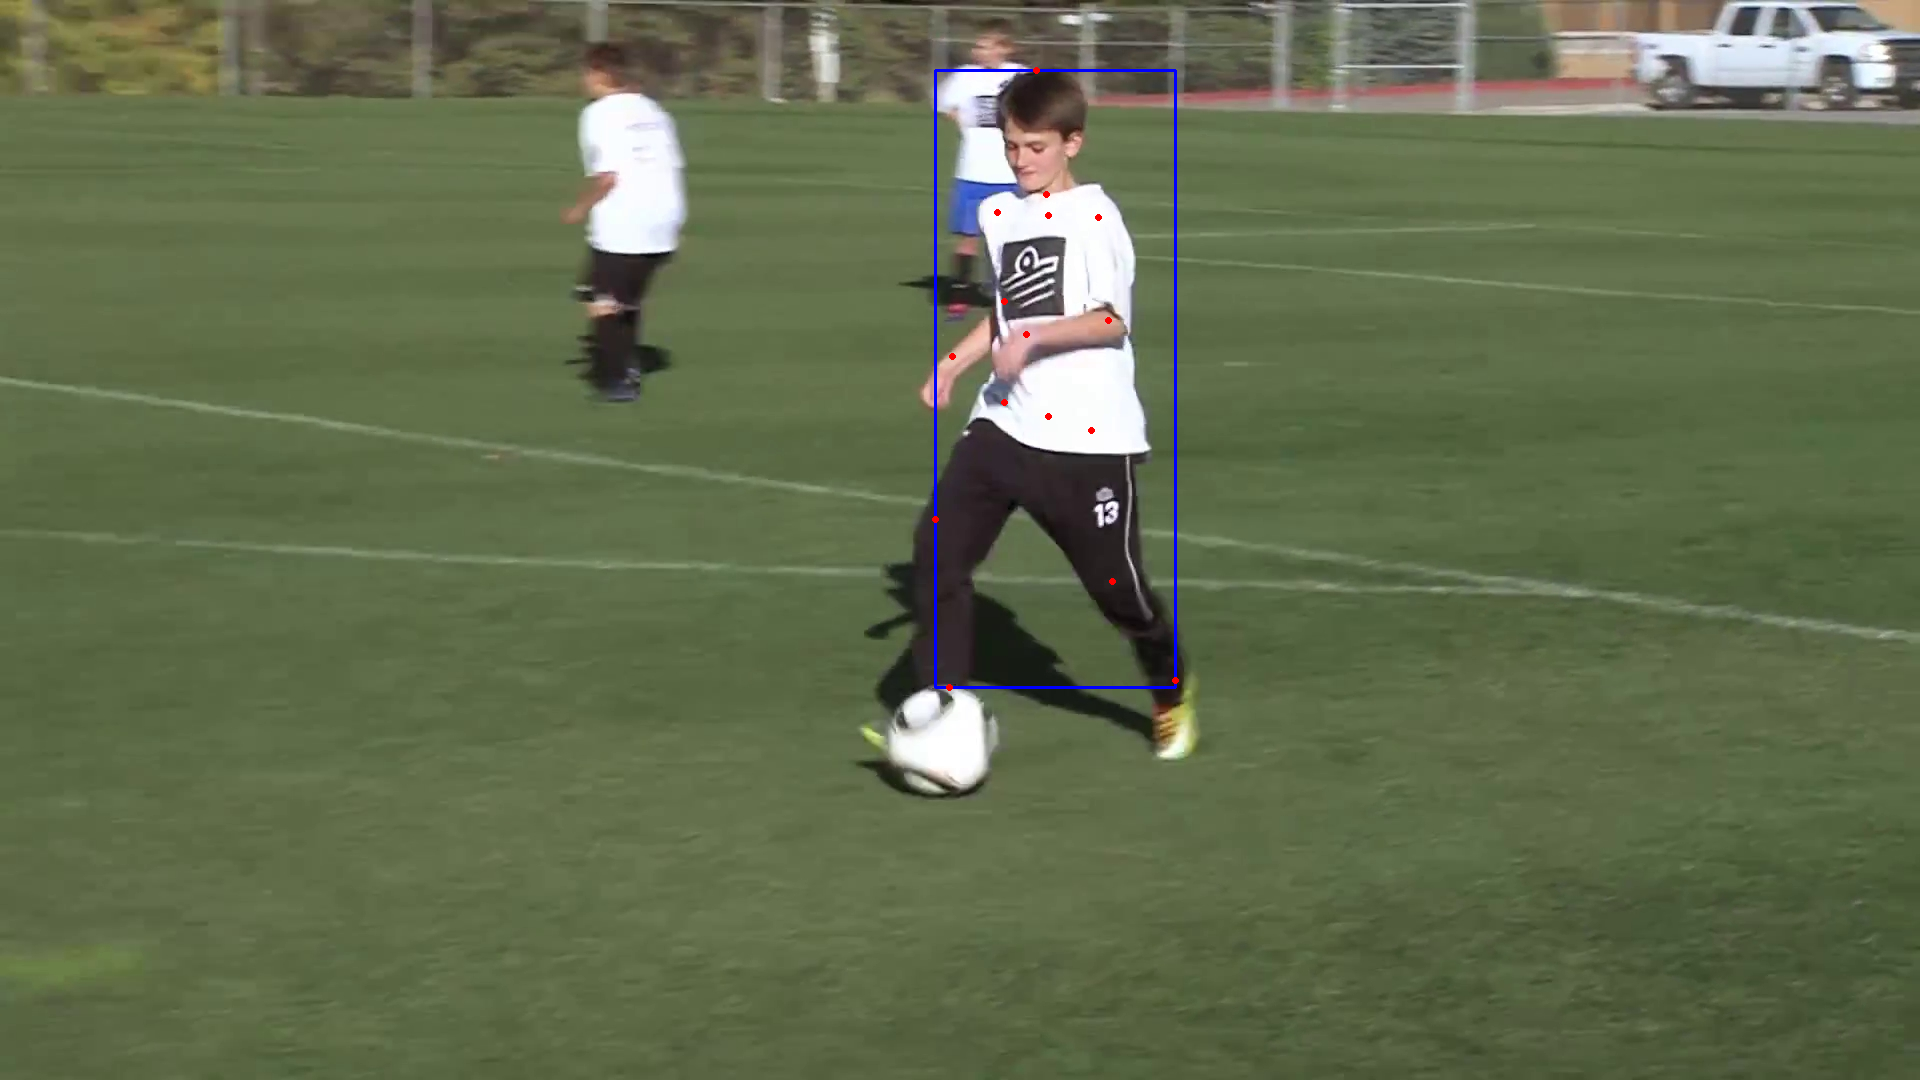

box dim: (240.0, 616.1552)
(1080, 1920, 3)
0.32459354396424794
(351, 623, 3)
(303, 22) (381, 222)


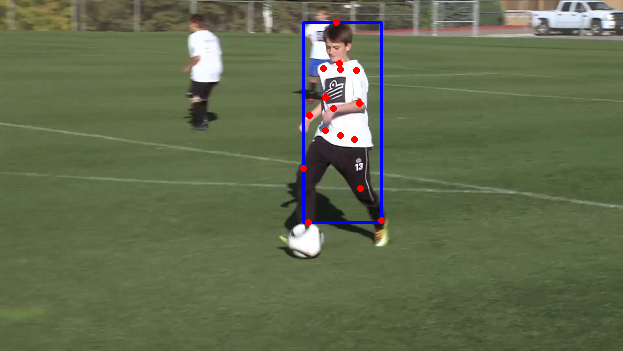

box dim: (77.90245055141946, 200.0)
[184 184]
[368 368]
(184, 184)
start [342 123]
end [710 491]


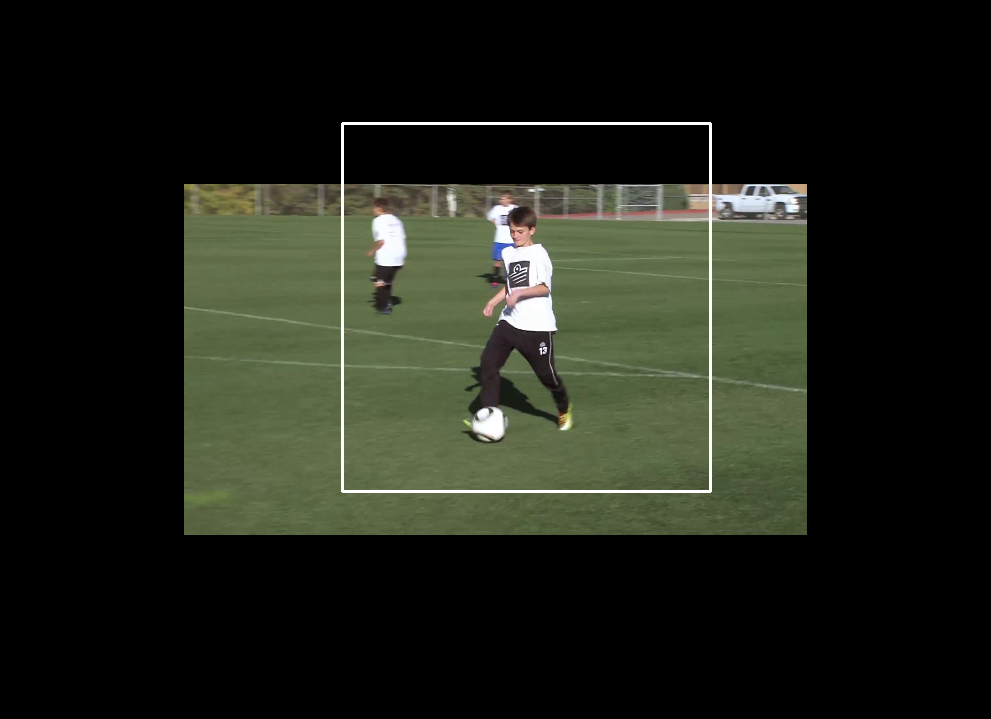

(719, 991, 3)


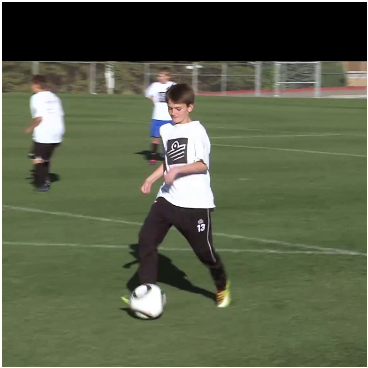

(368, 368, 3)
top_left (158, -61)
bottom_right (526, 306)
[150 145 167 196 202 223 182 182 181 178 151 167 165 198 201 175]
[283 229 191 200 249 281 196 130 124  83 176 158 129 131 164 169]


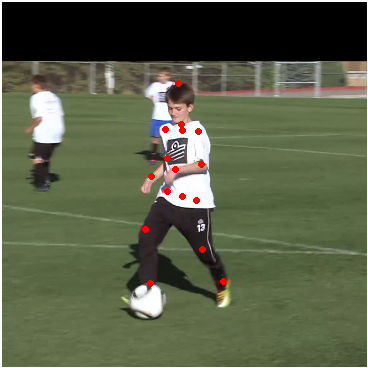

In [ ]:
image_dir = "/content/drive/My Drive/Datasets/images/"
annotation_dir = "/content/drive/My Drive/Datasets/mpii_human_pose_annotation.mat"

def annotate(image, bbox, out_labelX, out_labelY):
  anno_image = image.copy()
  tl, br = bbox.tl_br()
  cv2.rectangle(anno_image, tl, br, (255,0,0), 2, 1)
  for i in range (0, len(out_labelX)):
    cv2.circle(anno_image, (out_labelX[i], out_labelY[i]), 2, (0,0,255), 2)
  print(image.shape)
  print(tl, br)
  cv2_imshow(anno_image)

mpii = MpiiDataset(image_dir, annotation_dir)

if mpii.shuffle:
    mpii.labels = mpii.labels.sample(frac=1).reset_index(drop=True)

image_name = '014378517.jpg'

# Load Image
image_path = join(image_dir, image_name)
print (image_path)
image = cv2.imread(image_path)

# Cache labels
label = mpii.labels[mpii.labels['NAME'].str.contains(image_name)]

#Cache bounding box
bbox = mpii.bboxes[image_name]

top_left, bottom_right = bbox.tl_br()

print(top_left, bottom_right) 

out_labelX = (np.array(label.iloc[:, 1:32:2])).astype(np.int32)[0]
out_labelY = (np.array(label.iloc[:, 2:33:2])).astype(np.int32)[0]
annotate(image, bbox, out_labelX, out_labelY)

print ("box dim: " + str((bbox.width, bbox.height)))

print (image.shape)

# Bounding box target height, scale image to achieve this sizing
targetHeight = 200.0
scalingFactor = targetHeight / bbox.height

print(scalingFactor)

image = cv2.resize(image, (0, 0), fx=scalingFactor, fy=scalingFactor)
bbox.rescale((scalingFactor, scalingFactor))

out_labelX = (np.array(label.iloc[:, 1:32:2])* scalingFactor).astype(np.int32)[0]  
out_labelY = (np.array(label.iloc[:, 2:33:2])* scalingFactor ).astype(np.int32)[0]
annotate(image, bbox, out_labelX, out_labelY)

print ("box dim: " + str((bbox.width, bbox.height)))

top_left, bottom_right = bbox.tl_br()


bbox.expand(mpii.network_input_dim)

half_cross = np.full((1, 2), mpii.network_input_dim / 2).astype(int)[0]
full_cross = np.add(half_cross, half_cross)
half_cross_tuple = ( mpii.network_input_dim // 2,  mpii.network_input_dim // 2)

print(half_cross)
print(full_cross)
print(half_cross_tuple)

start = np.add(bbox.top_left.astype(int), half_cross)
end =  np.add(start, full_cross)

print ("start " + str(start) + "\nend " + str(end))
padded_image = np.pad(image, (half_cross_tuple, half_cross_tuple, (0, 0)), mode='constant')


cv2.rectangle(padded_image, tuple(start), tuple(end), (255,255,255), 2)
cv2_imshow(padded_image)
print(padded_image.shape)

cropped_image = padded_image[start[1]:end[1], start[0]:end[0]]
cv2_imshow(cropped_image)

print(cropped_image.shape)

top_left, _ = bbox.tl_br()

print("top_left " + str(top_left))
print ("bottom_right " + str(_))

out_labelX = (np.array(label.iloc[:, 1:32:2])* scalingFactor + half_cross[0] - start[0]).astype(np.int32)[0]  
out_labelY = (np.array(label.iloc[:, 2:33:2])* scalingFactor + half_cross[0] - start[1]).astype(np.int32)[0]
print(out_labelX)
print(out_labelY)#
out_label = np.hstack([out_labelY, out_labelX])

for i in range (0, len(out_labelX)):
  cv2.circle(cropped_image, (out_labelX[i], out_labelY[i]), 2, (0,0,255), 2)
cv2_imshow(cropped_image)

Assess accuracy of input images and features

In [ ]:
image_dir = '/content/dataset/images/'
image_name = '000040154.jpg'
img = cv2.imread(image_dir + image_name)

record = data[data.NAME==image_name]

if not record.empty:
  for i in range (1, 33, 2):
    xy = (int(record[MPII_FIELDS[i]][0]), int(record[MPII_FIELDS[i + 1]][0]))
    cv2.circle(img, xy, 4, (0,0,255), -1)
    label = MPII_FIELDS[i][0:-2]
    label_size = cv2.getTextSize(label,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    label_xy = (xy[0] - label_size[0][0]//2, xy[1] - label_size[0][1])
    cv2.putText(img,label, label_xy, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,255), 1)
cv2_imshow(img)

NameError: ignored

Define a Model class

Image preprocessing

Resized: (720, 1280, 3) -> (368, 368, 3)


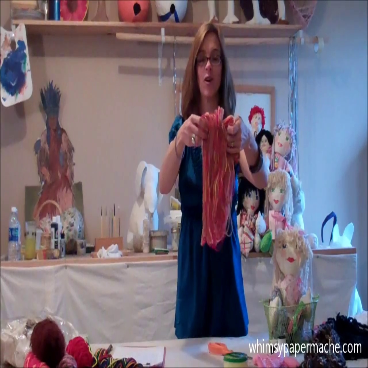

Resized: (720, 1280, 3) -> (368, 368, 3)


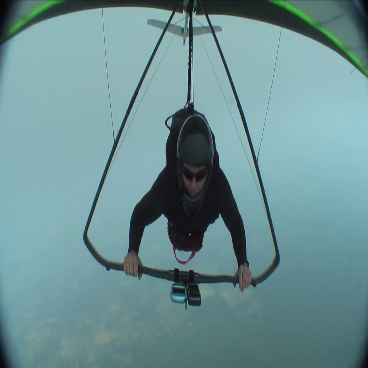

AttributeError: ignored

In [ ]:


image_dir = "/content/drive/My Drive/Datasets/Images/"
batch = [] 

image_name = '000024100.jpg'
img = cv2.imread(image_dir + image_name)
if not img.any():
  print ("No image found")
  exit()
batch.append(preprocess_image(img))

image_name = '000015774.jpg'
img = cv2.imread(image_dir + image_name)
if not img.any():
  print ("No image found")
  exit()
batch.append(preprocess_image(img))

cpm = ConvPoseMachine(3,16)

cpm(batch)
